In [3]:
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt

# k sample testing from hyppo
from hyppo.ksample import KSample
from hyppo.tools import rot_ksamp

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from math import log2, ceil

In [8]:
# samples to use per distribution
n_samples = 1000
# define number of estimators to use
n_trees = 10
# angles to pass to rxor
angle_sweep = range(0, 95, 5)
# num reps
mc_reps = 100

In [9]:
##### task unaware #####

# arrays to store gen error
pl_ge = np.zeros([mc_reps,19])
pl_ge_t0 = np.zeros([mc_reps,19])
uf1_ge = np.zeros([mc_reps,19])

for i in range(mc_reps):
    # dictionary to store task_id's for multiple reps
    mult_rep_id_dict = {}
    # generate task xor
    X_xor, y_xor = generate_gaussian_parity(n_samples)
    # generate test data
    X_xor_test, y_xor_test = generate_gaussian_parity(n_samples)
    # add xor data to dici,t
    mult_rep_id_dict[0] = X_xor, y_xor
    # testing with multiple runs
    for rep, angle in enumerate(angle_sweep):
        X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.radians(angle))
        # train single run of model
        progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
        # add xor data
        progressive_learner.add_task(
            mult_rep_id_dict[rep][0], mult_rep_id_dict[rep][1], n_estimators=n_trees
        )
        # init second LifeLongClassificationForest
        uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

        # k sample test, add new task rxor and learn new transformer if p <= 0.05
        if KSample(indep_test="Dcorr").test(mult_rep_id_dict[rep][0], X_rxor)[1] <= 0.05:
            progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees)
            progressive_learner.add_transformer(X_rxor, y_rxor, n_estimators=n_trees)
            uf1.add_task(X_rxor, y_rxor, n_estimators=2 * n_trees)

            # calc errors

            pl_ge[i,rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
            )
            pl_ge_t0[i,rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
            )
            uf1_ge[i,rep] = 1 - np.mean(uf1.predict(X_xor_test, task_id=0) == y_xor_test)

            # X_xor_rxor = np.concatenate((mult_rep_id_dict[rep][0], X_rxor), axis=0)
            # y_xor_rxor = np.concatenate((mult_rep_id_dict[rep][1], y_rxor), axis=0)
            # mult_rep_id_dict[rep + 1] = X_xor_rxor, y_xor_rxor
            # pass previous concatted data since we learned a new task
            mult_rep_id_dict[rep + 1] = mult_rep_id_dict[rep]

        else:
            # else add concatenated xor and rxor data
            X_xor_rxor = np.concatenate((mult_rep_id_dict[rep][0], X_rxor), axis=0)
            y_xor_rxor = np.concatenate((mult_rep_id_dict[rep][1], y_rxor), axis=0)
            progressive_learner.add_task(X_xor_rxor, y_xor_rxor, n_estimators=n_trees)
            uf1.add_task(X_xor_rxor, y_xor_rxor, n_estimators=2 * n_trees)
            mult_rep_id_dict[rep + 1] = X_xor_rxor, y_xor_rxor

            # calc gen erros
            pl_ge[i,rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
            )
            pl_ge_t0[i,rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
            )
            uf1_ge[i,rep] = 1 - np.mean(uf1.predict(X_xor_test, task_id=0) == y_xor_test)

        # print(progressive_learner.get_task_ids(), uf1.get_task_ids())

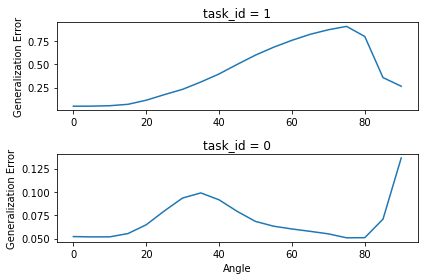

In [10]:
# fig, (ax1, ax2, ax3) = plt.subplots(3)
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(angle_sweep, np.mean(pl_ge,axis=0))  # task_id = 1
ax1.set_title("task_id = 1")
ax1.set_ylabel("Generalization Error")
ax2.plot(angle_sweep, np.mean(pl_ge_t0,axis=0))  # task_id = 0
ax2.set_title("task_id = 0")
ax2.set_xlabel("Angle")
ax2.set_ylabel("Generalization Error")
fig.tight_layout()
# fig.savefig('task_unaware_gen_error_100reps.pdf')